- 학습 된 모델로 결과를 보기 위해선 제너레이터가 필요 함 
- 제너레이터를 사용하기 전에 csvs, new_dir_df를 위한 사전 처리가 필요 함 

# 디렉토리 설정 및 데이터 로드 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip
!cp '/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_Classification/utils/init.py' ./

In [7]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

In [1]:
import os 
import pandas as pd 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
from init import init #초기 설정용 커스텀 패키지 
from make_df import make_df
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from albumentations import (
    Rotate,Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate,JpegCompression
)

In [2]:
csvs, new_dir_df key_lists = make_csvs_new_dir_df()

100%|██████████| 1606/1606 [00:09<00:00, 174.55it/s]


1606 1606


# 학습용 DF 생성 -> 아래 코드는 추후 제거 

# 전처리

In [77]:
#이미지 전처리 

def img_preprocess(img):
  shape = img.shape[0]
  preprocessed_img = img[int(shape*0.05):int(shape*0.95),int(shape*0.1):int(shape*0.9),:] #crop 
  preprocessed_img = cv2.cvtColor(preprocessed_img,cv2.COLOR_BGR2GRAY)
  preprocessed_img = cv2.resize(preprocessed_img,dsize=(image_size,image_size)) #resize Albu mentations -> vision 관련 augmentation document 
  preprocessed_img = preprocessed_img/255.
  return preprocessed_img 


def key_to_dir(key,new_dir_df):
  dir_of_key = new_dir_df[new_dir_df['key']==key]
  return dir_of_key

def read_imgs(img_dir_df): #224, 224, 19 용 
  temp_imgs = np.zeros(image_size*image_size*image_channels).reshape(image_size,image_size,image_channels)
  for i in range(len(img_dir_df)):
    temp_img = img_dir_df['dir'].iloc[i]
    temp_img = img_preprocess(cv2.imread(temp_img))
    temp_imgs[:,:,i] = temp_img 
  return temp_imgs



# 데이터 제너레이터

In [22]:
#이미지 전처리 

def img_preprocess(img,augmentation):
  shape = img.shape[0]
  preprocessed_img = img[int(shape*0.05):int(shape*0.95),int(shape*0.1):int(shape*0.9),:] #crop 
  if augmentation:
    preprocessed_img = transform(image=preprocessed_img)['image'] #augmentation
  preprocessed_img = cv2.cvtColor(preprocessed_img,cv2.COLOR_BGR2GRAY) #BGR -> GRAY scale 
  preprocessed_img = cv2.resize(preprocessed_img,dsize=(image_size,image_size)) #resize 
  preprocessed_img = preprocessed_img/255.#scaling 
  return preprocessed_img 


def key_to_dir(key,new_dir_df): #batch_key -> image directory 
  dir_of_key = new_dir_df[new_dir_df['key']==key]
  return dir_of_key

def read_imgs(img_dir_df,augmentation):  #image directory -> stacked image 
  temp_imgs = np.zeros(image_size*image_size*image_channels).reshape(image_size,image_size,image_channels)
  for i in range(len(img_dir_df)):
    temp_img = img_dir_df['dir'].iloc[i]
    temp_img = img_preprocess(cv2.imread(temp_img),augmentation)
    temp_imgs[:,:,i] = temp_img 
  return temp_imgs

def minmax(index,out_column):
  scaling_value = np.array(csvs[out_column].iloc[index])
  min = np.min(scaling_value,axis=0)
  max = np.max(scaling_value,axis=0)
  return max,min


In [23]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math


class DataGenerator(Sequence):
  def __init__(self,
                 new_dir_df,
                 csvs,
                 key_index,
                 output_column,
                 batch_size: int,
                 augmentation: bool = False,
                 shuffle: bool = False,
                 rescale:bool = True) -> None:
        self.input_columns = input_columns 
        self.key_index = key_index
        self.key_lists = key_lists
        self.output_columns = output_column
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.rescale =rescale
        self.new_dir_df = new_dir_df
        self.csvs = csvs

  def __len__(self):
    return math.ceil(len(self.key_lists) / self.batch_size)
    
  def on_epoch_end(self):
    self.indices = np.arange(len(self.key_lists))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.key_lists = self.key_lists[self.indices]
      
      
  def __getitem__(self, index):
    #key list에서 batch_keys 뽑아 냄 
    #이 batch_keys를 기반으로 image와 csv 추출 함 
    self.batch_keys = self.key_lists[index*self.batch_size:(index+1)*self.batch_size]
    self.batch_keys.sort()

    #imgs 추출 
    temp_imgs = []
    for key in range(len(self.batch_keys)):
      img_dir_df = key_to_dir(self.batch_keys[key],self.new_dir_df) #key에 해당하는 dir들 추출 
      temp_img = read_imgs(img_dir_df,self.augmentation)#dir 대로 이미지들 추출 
      temp_imgs.append(temp_img)
    input_imgs = np.array(temp_imgs).astype(np.float)

    #minmax 
    csvs_input_max, csvs_input_min = minmax(self.key_index,self.input_columns)
    csvs_output_0_max,csvs_output_0_min = minmax(self.key_index, self.output_columns)

    #input_csvs
    temp_csvs = self.csvs[self.csvs['병록번호'].apply(lambda x: x in self.batch_keys)]
    temp_csvs = temp_csvs.sort_values(by=['병록번호'])
    temp_csvs = temp_csvs.reset_index().drop(columns='index')
    input_csvs = temp_csvs[input_columns]
    input_csvs = (np.array(input_csvs)-csvs_input_min)/(csvs_input_max-csvs_input_min)
    input_csvs = np.array(input_csvs)

    #output_csvs
    temp_csvs = self.csvs[self.csvs['병록번호'].apply(lambda x: x in self.batch_keys)]
    temp_csvs = temp_csvs.sort_values(by=['병록번호'])
    temp_csvs = temp_csvs.reset_index().drop(columns='index')
    output_csvs = temp_csvs[self.output_columns]
    output_csvs = np.array(output_csvs)
    output_csvs = (output_csvs - csvs_output_0_min)/(csvs_output_0_max-csvs_output_0_min).astype(np.float)

    return [input_imgs,input_csvs],output_csvs
    


# 모델 학습 결과 

In [4]:
# !pip install tensorflow-addons
import tensorflow_addons 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Model

In [5]:
model_lists = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_Classification/models/4번/model_lists4.pickle')
history_lists = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_Classification/models/4번/history_lists4.pickle')

## Loss 

In [17]:
def loss_ensemble(history_lists,mode):
  loss_list = []
  for i in range(len(history_lists)):
    history = history_lists[i]
    loss = history.history[mode]
    loss_list.append(loss)
  loss_list = np.array(loss_list)
  loss_list = np.mean(loss_list,axis=0)
  return loss_list 
def loss_plot(history_lists,column):
  mean_loss = loss_ensemble(history_lists,'loss')
  mean_val_loss = loss_ensemble(history_lists,'val_loss')
  plt.figure(figsize=(10,7))
  plt.plot(mean_loss,label = 'loss')
  plt.plot(mean_val_loss,label = 'val_loss')
  plt.title(f'Columns : {column}',fontsize='xx-large')
  plt.legend(fontsize = 'xx-large')
  plt.show()
  print(f'최종 loss = {mean_loss[-1]}')
  print(f'최종 val loss = {mean_val_loss[-1]}')

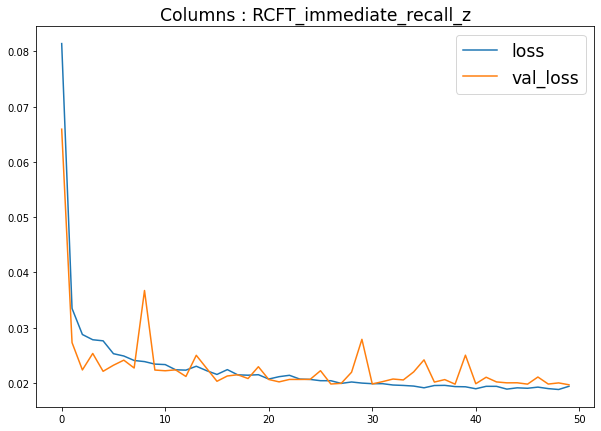

최종 loss = 0.01941396047671636
최종 val loss = 0.01968719872335593


In [18]:
loss_plot(history_lists,'RCFT_immediate_recall_z')

## Metrics

In [19]:
input_columns = ['만나이','교육년수']
image_size = 224
image_channels = 19 
BATCH_SIZE= 32

#예측할 output_columns 들 
output_columns = ['SVLT_recall_total_score_z',
       'SVLT_Delayed_recall_z', 'SVLT_recognition_score_z',
       'RCFT_immediate_recall_z', 'RCFT_delayed_recall_z',
       'RCFT_recognition_score_z', 'K_MMSE_total_score_z',
       'SNSB_II_Domain_Attention_z', 'SNSB_II_Domain_Language_z',
       'SNSB_II_Domain_Visuospatial_z', 'SNSB_II_Domain_Memory_z',
       'SNSB_II_Domain_Frontal_z']

#Stratified KFold를 위해 -1을 기준으로 분류 된 E_output_columns들 사용 
E_output_columns = {}
for output_column in output_columns:
  E_output_columns[output_column] = 'E_' + output_column

def minmax(index,out_column):
  scaling_value = np.array(csvs[out_column].iloc[index])
  min = np.min(scaling_value,axis=0)
  max = np.max(scaling_value,axis=0)
  return max,min

In [20]:
def descaling(value):
  origin = value*(csvs_output_0_max-csvs_output_0_min) + csvs_output_0_min
  return origin
def embedding(value):
  if value >=-1:
    return 0 
  else:
    return 1 
def score_regression_predict(model,generator,index):
  y_ = model.predict(generator)
  predicted = pd.DataFrame(y_)[0].map(descaling)
  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report

  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))

## Regression Result 

In [ ]:
#Stratified Kfold indexing 용 
test_index = np.arange(1446,1606) #test 데이터 : 1446 ~ 1606 사용 

output_column = output_columns[3] #예측할 컬럼 선택 
x = key_indexes = np.arange(1445) #Train - valid : 0 ~ 1445 데이터 사용 
y = np.array(csvs[E_output_columns[output_column]][:1445]) 

#Stratified Kfold 
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

predicted_train_lists = []
predicted_valid_lists = []
predicted_test_lists = []


n = 0 #Fold 회차 확인용 
for train_index, valid_index in skf.split(x, y):
  csvs_input_max, csvs_input_min = minmax(train_index,input_columns)
  csvs_output_0_max,csvs_output_0_min = minmax(train_index, output_column)

  #제너레이터 
  train_generator = DataGenerator(new_dir_df,
                                csvs,
                                train_index,
                                output_column,
                                batch_size=BATCH_SIZE,
                                augmentation=False,
                                  shuffle=True)
  valid_generator = DataGenerator(new_dir_df,
                                csvs,
                                valid_index,
                                output_column,
                                batch_size=BATCH_SIZE,
                                augmentation=False,
                                shuffle=False)
  test_generator = DataGenerator(new_dir_df,
                               csvs,
                               test_index,
                               output_column,
                               batch_size=BATCH_SIZE,
                               augmentation=False,
                               shuffle=False)
  model = model_lists[n]
  train_y_ = model.predict(train_generator)
  train_predicted = pd.DataFrame(train_y_)[0].map(descaling)
  predicted_train_lists.append(train_predicted)

  valid_y_ = model.predict(valid_generator)
  valid_predicted = pd.DataFrame(valid_y_)[0].map(descaling)
  predicted_valid_lists.append(valid_predicted)
  
  test_y_ = model.predict(test_generator)
  test_predicted = pd.DataFrame(test_y_)[0].map(descaling)
  predicted_test_lists.append(test_predicted)

## classification_report

## ROC-AUC-AUROC